In [1]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

In [20]:
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

from cancer_estimator_model import datasets

# Carregar o dataset 
df = datasets.get_integrated_dataset()
display(df.head(10).T)
# df.info()

,0,1,2,3,4,5,6,7,8,9
AGE,69.0,74.0,59.0,63.0,63.0,75.0,52.0,51.0,68.0,53.0
SMOKING,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
YELLOW_FINGERS,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0
ANXIETY,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
PEER_PRESSURE,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
CHRONIC_DISEASE,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
FATIGUE,1,1,1,0,0,1,1,1,1,0
ALLERGY,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
WHEEZING,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
ALCOHOL_CONSUMING,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [22]:
# Dividir o conjunto de dados em features (X) e variável alvo (y)
dropped_columns = ['LUNG_CANCER_RISK','COUNTRY', 'SOURCE', 'SEVERITY', 'BALANCED_DIET']
X = df.drop(columns=dropped_columns)
y = df['LUNG_CANCER_RISK'].fillna(-1)

# Tratar valores ausentes nas colunas categóricas
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
for col in categorical_cols:
    X[col].fillna('missing', inplace=True)


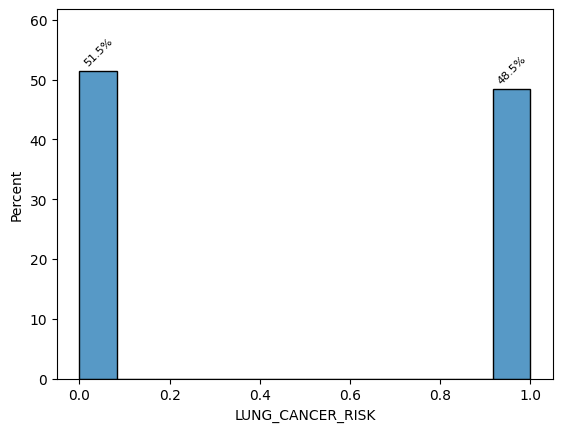

In [23]:
def plot_y_distribution(y):
    # Criando distribuição da variável resposta estimada
    ax = sns.histplot(y, stat='percent')
    
    
    # add annotations
    for c in ax.containers:
    
        # custom label calculates percent and add an empty string so 0 value bars don't have a number
        labels = [f'{w:0.1f}%' if (w := v.get_height()) > 0 else '' for v in c]
    
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=8, rotation=45, padding=2)
        
        ax.margins(y=0.2)
    plt.show()
plot_y_distribution(y[df.SOURCE != 3])

# Cross validation with catboost regression

In [24]:
# Criar o modelo CatBoostRegressor
model = CatBoostRegressor(
    iterations=500, 
    depth=6,
    eval_metric="RMSE",  # Métrica apropriada para regressão
    learning_rate=0.1, 
    cat_features=categorical_cols,  # Passar as colunas categóricas
    verbose=0
)

# Definir o número de dobras para a validação cruzada
n_folds = 5

# Definir um limiar de decisão para converter previsões contínuas em classes
decision_threshold = 0.6

def p_at_k(y_true, y_pred, k=100):
    k_values = y_pred.sort_values(ascending=False).sort_index().head(k)
    y_true_sorted = y_true.loc[k_values.index]
    y_pred_class = (k_values >= decision_threshold).astype(int)  # Converter previsões contínuas para classes com base no limiar
    tp = ((y_pred_class == 1) & (y_true_sorted == 1)).sum()
    fp = ((y_pred_class == 1) & (y_true_sorted == 0)).sum()
    p_at_k = tp / (tp + fp)
    print(f"p@k={round(p_at_k, 3)} | TP = {tp} / FP={fp}")
    return p_at_k

# Criar o objeto de validação cruzada estratificada
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
scores = []
for fold, (mask_train, mask_test) in enumerate(skf.split(X, y)): 
    y_train = y.loc[mask_train]
    X_train = X.loc[mask_train].loc[y_train != -1]
    y_train = y_train.loc[y_train != -1]
    X_test = X.loc[mask_test]
    y_test = y.loc[mask_test]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = pd.Series(y_pred, index=X_test.index)
    scores.append(custom_scoring(y_test, y_pred))

rscores = np.round(scores, decimals=4)
mean = np.round(np.mean(scores), decimals=4)
std = np.round(np.std(scores), decimals=4)
# Exibir as pontuações de validação cruzada
print(f"Pontuações de validação cruzada (p@(k={k})):", scores)
# Exibir a média das pontuações de validação cruzada
print(f"Média e desvio padrão das pontuações de validação cruzada: {mean}±{std}")

p@k=0.947 | TP = 72 / FP=4
p@k=0.983 | TP = 59 / FP=1
p@k=0.921 | TP = 70 / FP=6
p@k=0.885 | TP = 54 / FP=7
p@k=0.957 | TP = 67 / FP=3
Pontuações de validação cruzada (p@(k=100)): [0.9473684210526315, 0.9833333333333333, 0.9210526315789473, 0.8852459016393442, 0.9571428571428572]
Média e desvio padrão das pontuações de validação cruzada: 0.9388±0.0334


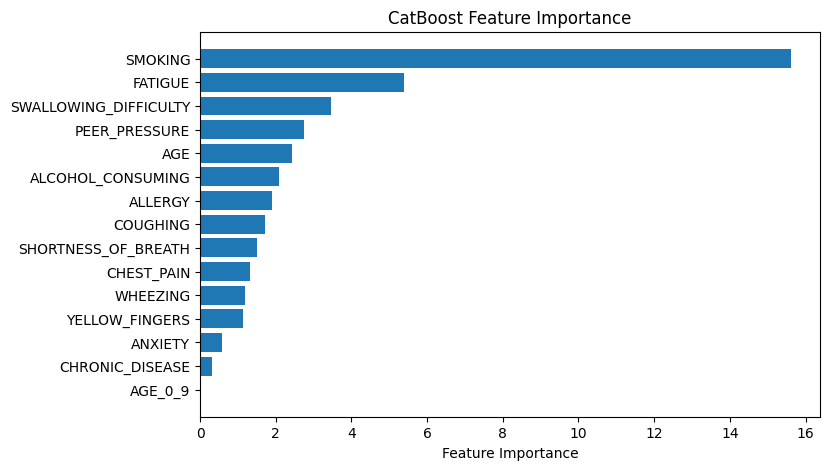

In [18]:
# plot feature importance
n_features = 15
feature_importance = model.get_feature_importance(type='FeatureImportance')[:n_features]
feature_names = model.feature_names_
sorted_idx = feature_importance.argsort()[:n_features]

plt.figure(figsize=(8,5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()